In [1]:
import os
import sys
from pathlib import Path
sys.path.insert(1, str(Path(os.getcwd()).parent / "src"))

In [2]:
import data_loader
from utils import *
from mcs_function import *
from mbll_functions import *
from plotting import *
import config
import pickle
from scipy.optimize import least_squares
import pmcx
import matplotlib.pyplot as plt
from sympy import lambdify, symbols, dsolve, Function, exp, Eq, oo, limit, Add, Mul, solve, sqrt, log

Compare the reflectance formula to Monte Carlo Simulations...

In [3]:
gray_matter_mcs_data = np.loadtxt(config.pl_dir / "gray_matter_mcs.txt")
blood_vessel_mcs_data = np.loadtxt(config.pl_dir / "blood_vessel_pure_mcs.txt")

In [4]:
mcs_data = gray_matter_mcs_data

In [5]:
A_carp_vals = A_carp(mcs_data[:, 1], mcs_data[:, 2], 0.85, 1.36)
A_patterson_vals = A_patterson(mcs_data[:, 1], mcs_data[:, 2] * (1-0.85), 1.36)

In [6]:
mu_a_matrix = data_loader.DataLoader.absorption_coefs(
    mcs_data[:, 0],
    use_diff_oxycco=False,
    use_water_and_fat=True
)

c = data_loader.DataLoader.tissue_parameters["gray matter"][0]
mu_a_vals = mu_a_matrix @ c
a, b = data_loader.DataLoader.tissue_parameters["gray matter"][1]
mu_s_red_vals = a * (mcs_data[:, 0] / 500) **(-b)


In [7]:
mu_a_vals / 10 - mcs_data[:, 1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
mu_s_red_vals / (1-0.85) / 10 - mcs_data[:, 2]

array([ 0.00000000e+00,  0.00000000e+00, -7.10542736e-15,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.55271368e-15,  0.00000000e+00,
       -3.55271368e-15,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.55271368e-15,  0.00000000e+00,  3.55271368e-15,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.77635684e-15,
        1.77635684e-15,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.77635684e-15,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.77635684e-15,  0.00000000e+00,  8.88178420e-16,
        8.88178420e-16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  8.88178420e-16,
        0.00000000e+00,  0.00000000e+00, -8.88178420e-16,  0.00000000e+00,
        0.00000000e+00, -8.88178420e-16,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.44089210e-16])

In [15]:
A_carp_vals = A_carp_concentrations(
    mcs_data[:, 0],
    mu_a_matrix,
    c, a, b, 0.85, 1.34
)

In [13]:
A_carp_vals.shape

(51, 1)

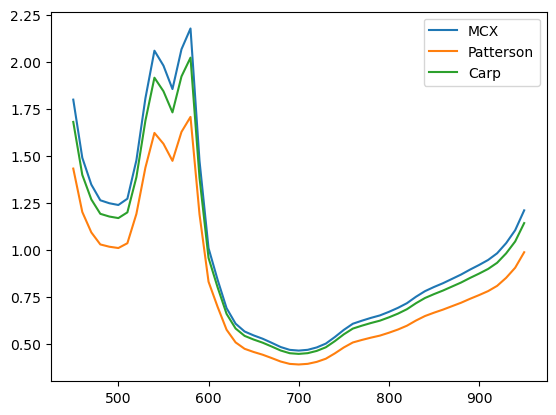

In [16]:
plot_spectra((-np.log(mcs_data[:, 3]), A_patterson_vals, A_carp_vals), mcs_data[:, 0], labels=["MCX", "Patterson", "Carp"])

Patterson formula slightly underestimates $A$, Carp's formula very precise.

# Patterson formula
Check that the solution to the ODE provided by Patterson et. al (1989) gives the diffuse reflectance.

In [ ]:
mu_a, mu_s_red, g = symbols("mu_a mu_s_red g", positive=True)
k, z, d0 = symbols(r"k z d_0")

In [ ]:
theta = Function(r"\theta")(z)
thetap = theta.diff(z)
thetapp = theta.diff(z, 2)

In [ ]:
D = 1 / (3*(mu_a + mu_s_red))

In [ ]:
eq = Eq(- D*thetapp + mu_a*theta, mu_s_red*exp(-(mu_a + mu_s_red)*z))

In [ ]:
eq

$d_0$ is a temporary variable that describes $\frac{\partial \theta}{\partial z} |_{z=0}$

In [ ]:
ics={theta.subs(z, 0): 2*D*k*d0, thetap.subs(z, 0): d0}

In [ ]:
res_theta = dsolve(eq, theta, ics=ics)

The result is of the form $$\theta(z) = a\exp(k_1z) + b\exp(k_2 z) + c\exp(k_3 z)$$

Proof:

In [ ]:
res_theta.lhs

In [ ]:
assert res_theta.rhs.func == Add
for term in res_theta.rhs.args:
    assert term.func == Mul
    assert all(z not in constant.free_symbols for constant in term.args[:-1])
    print(f"{term.args[-1]}  ---> {limit(term.args[-1], z, oo, '+')}")

Result: Only the first term does not go to 0 for $z \rightarrow 0$. To ensure that the entire term goes to zero, the first constant $a$ must be zero.

In [ ]:
a = Mul(*res_theta.rhs.args[0].args[:-1])
assert z not in a.free_symbols

In [ ]:
res_d0 = solve(Eq(a, 0), d0)

In [ ]:
len(res_d0)

With newly determined value for $\frac{\partial \theta}{\partial z} |_{z = 0}$, lets solve the ODE again.

In [ ]:
ics={theta.subs(z, 0): 2*D*k*res_d0[0], thetap.subs(z, 0): res_d0[0]}

In [ ]:
res_theta2 = dsolve(eq, theta, ics=ics)

Check that $\theta(0)$ equals the expected formula for reflectance.

In [ ]:
albedo = mu_s_red / (mu_a + mu_s_red)

In [ ]:
R_patterson_formula = albedo / (1 + 2*k * (1-albedo) + (1 + 2*k/3) * sqrt(3 * (1 - albedo)))

In [ ]:
R_computed_formula = res_theta2.rhs.subs(z, 0) / (2 * k)

In [ ]:
(R_computed_formula - R_patterson_formula).simplify() == 0

Compute the derivatives of $A=\log(R)$

In [ ]:
A_patterson_formula = -log(R_patterson_formula)

In [ ]:
f = g*g
g_star = g/(1+g)
mu_s = mu_s_red / (1-g)
mu_s_star = mu_s * (1-f)
mu_t_star = mu_a + mu_s_star
mu_tr = (mu_a + mu_s * (1-g))
mu_eff = sqrt(3 * mu_a * mu_tr)
h = 2 / (3 * mu_tr)
alpha = 3*mu_s_star*(mu_t_star + g_star *mu_a) / (mu_eff ** 2 - mu_t_star**2)
# NOTE: Carp calls k "A", I use "k" to stay consistent with Patterson
# Carp provides a different, and more accurate way to calculate k
beta = (-alpha * (1+k*h*mu_t_star) - 3*k*h*g_star*mu_s_star) / (1 + k*h*mu_eff)
R_carp = (alpha + beta) / (2 * k)
A_carp_formula = -log(R_carp)


Verify both formulas

In [ ]:
A_carp_symbolic = lambdify((mu_a, mu_s_red, g, k), A_carp_formula)
def A_carp_symbolic_wrapper(mu_a, mu_s_red, g, n):
    k = -0.13755 * (n**3) + 4.3390 * (n**2) - 4.90466 * n + 1.6896
    return A_carp_symbolic(mu_a, mu_s_red, g, k)

A_carp_symbolic_vals = A_carp_symbolic_wrapper(mcs_data[:, 1], mcs_data[:, 2] * (1-0.85), 0.85, 1.36)

In [ ]:
A_patterson_symbolic = lambdify((mu_a, mu_s_red, k), A_patterson_formula)
def A_patterson_symbolic_wrapper(mu_a, mu_s_red, n):
    # patterson uses different, and (for far-field) less accurate way to calculate k
    # to stay consistent with reference, I use it anyway
    rd = -1.44 * np.power(n, -2) * 0.71 / n + 0.668 + 0.0636 * n
    k = (1 + rd) / (1 - rd)
    return A_patterson_symbolic(mu_a, mu_s_red, k)

A_patterson_symbolic_vals = A_patterson_symbolic_wrapper(mcs_data[:, 1], mcs_data[:, 2] * (1-0.85), 1.36)


In [ ]:
assert np.allclose(A_carp_symbolic_vals, A_carp_vals)
assert np.allclose(A_patterson_symbolic_vals, A_patterson_vals)

In [ ]:
plot_spectra((A_patterson_symbolic_vals, A_carp_symbolic_vals, A_patterson_vals+0.02, A_carp_vals+0.02), mcs_data[:, 0], labels=["Patterson, symbolic", "Carp, symbolic", "Patterson", "Carp"])

Derivative to $\mu_a$, i.e. the pathlength:

In [ ]:
A_patterson_formula.diff(mu_a).simplify()

In [ ]:
A_patterson_formula.diff(mu_s_red).simplify()

In [ ]:
A_carp_formula.diff(mu_a)
# A_carp_formula.diff(mu_a).simplify() # does not terminate

In [ ]:
A_carp_formula.diff(mu_s_red)

Save all derivatives as pickle objects

In [ ]:
with open(config.diffusion_derivative_dir / "carp.pickle", "wb") as f:
    pickle.dump((A_carp_formula.diff(mu_a), A_carp_formula.diff(mu_s_red)), f)

In [ ]:
with open(config.diffusion_derivative_dir / "patterson.pickle", "wb") as f:
    pickle.dump((A_patterson_formula.diff(mu_a), A_patterson_formula.diff(mu_s_red)), f)

In [ ]:
with open(config.diffusion_derivative_dir / "carp_test.pickle", "wb") as f:
    pickle.dump(A_carp_formula, f)

In [ ]:
with open(config.diffusion_derivative_dir / "carp_test.pickle", "rb") as f:
    A_carp_formula = pickle.load(f)